In [1]:
# Importing all required packages and ignore warnings 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, brier_score_loss
import statsmodels.api as sm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import train_test_split
from collections import Counter
from collections import OrderedDict
from itertools import islice
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from IPython.display import Markdown, display
import warnings
import time
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
pd.options.display.max_colwidth = 100

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kshamajha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading the all cleaned data

In [2]:
review_df_final = pd.read_csv("reviews_dataset_new.csv")
review_df_final.shape

(437511, 23)

In [3]:
model_results = pd.DataFrame()
def get_model_metrics(y_test, y_pred, model_name):
    display(Markdown("------ "))
    display(Markdown("### " + model_name + " Model Metrics Summary : "))
    cm = confusion_matrix(y_test,y_pred)
    display(Markdown("#### Confusion Matrix : "))

    display(cm)
    accuracy = round(accuracy_score(y_test,y_pred), 2)
    precision = round(precision_score(y_test,y_pred), 2)
    recall = round(recall_score(y_test,y_pred), 2)
    auc = round(roc_auc_score(y_test,y_pred), 2)
    f1 = round(f1_score(y_test,y_pred), 2)
    brier_loss = round(brier_score_loss(y_test, y_pred), 4)
    
    data = [[model_name, accuracy, precision, recall, auc, f1, brier_loss]] 
    df = pd.DataFrame(data, columns = ['Model Name', 'Accuracy', 'Precision', 'Recall', 'AUC', 'F1', 'Brier Loss'])
    global model_results 
    model_results = model_results.append(df, ignore_index=True)
    return df 

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,1), min_df = 0.1) 
 
# vectorize the complete text
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(review_df_final['ReviewText'])


In [5]:
(tfidf_vectorizer_vectors)

<437511x12 sparse matrix of type '<class 'numpy.float64'>'
	with 939107 stored elements in Compressed Sparse Row format>

In [6]:
review_df_final.head(2)

,OverallCompanyRating,Verified,TotalEmployees,year,quarter,month,CareerGrowth,SalaryandBenefits,WorkLifeBalance,WorkSatisfaction,CompanyCulture,SkillDevelopment,JobSecurity,Fortune500,Global2000,MNC,conglomerate,Govt,ReviewText,ReviewText_CharCount,ReviewText_WordCount,firm_noofreviews,fake
0,1,0,100001,2021,3,9,1,2,1,1,1,1,1,0,0,1,0,0,work life balance treat employee slaves set un realistic goal achieve either work hrs make alot ...,497,76,599,1
1,5,1,100001,2021,1,2,5,5,5,5,5,5,5,0,0,1,0,0,good work environment culture teammates supportive management transparent huge cafeteria gaming ...,316,44,599,0


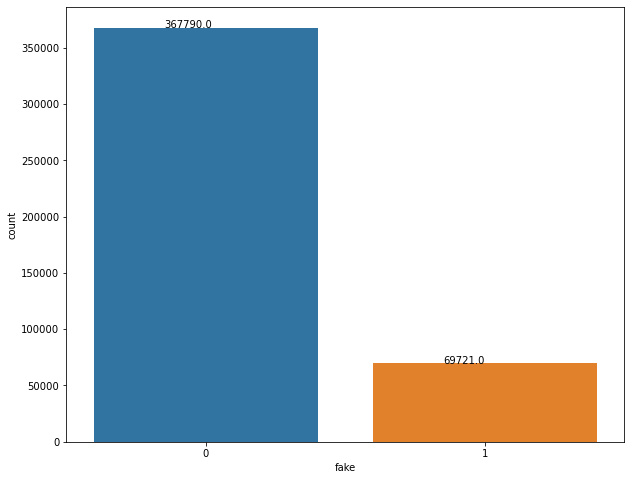

In [7]:
# Plot to show the fake review counts
plt.figure(figsize=(10,8))
ax = sns.countplot(x='fake', data=review_df_final)
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.show()

In [8]:
#dividing data into test & train to build fake review detection model
# Putting feature variable to X
X = tfidf_vectorizer_vectors

# Putting response variable to y
y = review_df_final["fake"]
# split into 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state =100)

In [9]:
# describes info about train and test set
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (306257, 12)
Number transactions y_train dataset:  (306257,)
Number transactions X_test dataset:  (131254, 12)
Number transactions y_test dataset:  (131254,)


In [10]:
# Print fake ratio in train data
print("Fake Ratio:")
y_train.value_counts()*100/y_train.size

Fake Ratio:


0    84.024855
1    15.975145
Name: fake, dtype: float64

### Training the model
## Logistic Regression with unbalanced data

In [11]:
st = time.process_time()
lr = LogisticRegression()
lr.fit(X_train,y_train)
et = time.process_time()
res = et - st
print('CPU Execution time:', res, 'seconds')

CPU Execution time: 0.8339359999999996 seconds


In [12]:
y_pred = lr.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[107510   2948]
 [ 17352   3444]]
0.8453380468404772
              precision    recall  f1-score   support

           0       0.86      0.97      0.91    110458
           1       0.54      0.17      0.25     20796

    accuracy                           0.85    131254
   macro avg       0.70      0.57      0.58    131254
weighted avg       0.81      0.85      0.81    131254



In [13]:
# Print the model metrics
get_model_metrics(y_test, y_pred ,'Logistic Regression with unbalanced data')

------ 

### Logistic Regression with unbalanced data Model Metrics Summary : 

#### Confusion Matrix : 

array([[107510,   2948],
       [ 17352,   3444]])

,Model Name,Accuracy,Precision,Recall,AUC,F1,Brier Loss
0,Logistic Regression with unbalanced data,0.85,0.54,0.17,0.57,0.25,0.1547


### The data is highly unbalanced. Lets do the model building by balancing data.

In [14]:
from imblearn.combine import SMOTETomek
st = time.process_time()
os=SMOTETomek(0.75)
X_train_ns,y_train_ns=os.fit_resample(X_train,y_train)
et = time.process_time()
res = et - st
print('CPU Execution time:', res, 'seconds')

CPU Execution time: 2745.9559400000003 seconds


In [15]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_train_ns.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_ns.shape))
 
print("After OverSampling, counts of label '1': {}".format(sum(y_train_ns == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_ns == 0)))

Before OverSampling, counts of label '1': 48925
Before OverSampling, counts of label '0': 257332 

After OverSampling, the shape of train_X: (450181, 12)
After OverSampling, the shape of train_y: (450181,) 

After OverSampling, counts of label '1': 192924
After OverSampling, counts of label '0': 257257


### Training the model with balanced data
## Logistic Regression

In [16]:
st = time.process_time()
lr2 = LogisticRegression()
lr2.fit(X_train_ns,y_train_ns)
et = time.process_time()
res = et - st
print('CPU Execution time:', res, 'seconds')

CPU Execution time: 0.9148499999996602 seconds


In [17]:
y_pred2 = lr2.predict(X_test)
print(confusion_matrix(y_test,y_pred2))
print(accuracy_score(y_test,y_pred2))
print(classification_report(y_test,y_pred2))

[[88194 22264]
 [ 4865 15931]]
0.7933091562923796
              precision    recall  f1-score   support

           0       0.95      0.80      0.87    110458
           1       0.42      0.77      0.54     20796

    accuracy                           0.79    131254
   macro avg       0.68      0.78      0.70    131254
weighted avg       0.86      0.79      0.81    131254



In [18]:
# Print the model metrics
get_model_metrics(y_test, y_pred2 ,'Logistic Regression')

------ 

### Logistic Regression Model Metrics Summary : 

#### Confusion Matrix : 

array([[88194, 22264],
       [ 4865, 15931]])

,Model Name,Accuracy,Precision,Recall,AUC,F1,Brier Loss
0,Logistic Regression,0.79,0.42,0.77,0.78,0.54,0.2067


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


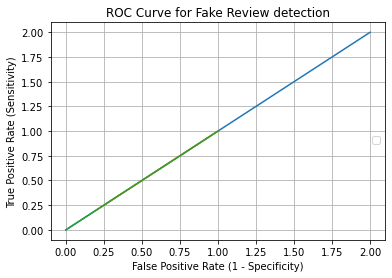

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve
plt.plot(roc_curve(y_test, y_pred2), roc_curve(y_test, y_pred2))
plt.title('ROC Curve for Fake Review detection')
plt.grid()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(bbox_to_anchor=(1.0, .5))
plt.show()

### Training the model
## Random Forest

In [20]:
st = time.process_time()
rf=RandomForestClassifier()
rf.fit(X_train_ns,y_train_ns)
et = time.process_time()
res = et - st
print('CPU Execution time:', res, 'seconds')

CPU Execution time: 111.25884300000007 seconds


In [21]:
y_pred3=rf.predict(X_test)
print(confusion_matrix(y_test,y_pred3))
print(accuracy_score(y_test,y_pred3))
print(classification_report(y_test,y_pred3))

[[87061 23397]
 [ 4534 16262]]
0.7871988663202645
              precision    recall  f1-score   support

           0       0.95      0.79      0.86    110458
           1       0.41      0.78      0.54     20796

    accuracy                           0.79    131254
   macro avg       0.68      0.79      0.70    131254
weighted avg       0.86      0.79      0.81    131254



In [22]:
# Print the model metrics
get_model_metrics(y_test, y_pred3 ,'Random Forest')

------ 

### Random Forest Model Metrics Summary : 

#### Confusion Matrix : 

array([[87061, 23397],
       [ 4534, 16262]])

,Model Name,Accuracy,Precision,Recall,AUC,F1,Brier Loss
0,Random Forest,0.79,0.41,0.78,0.79,0.54,0.2128


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


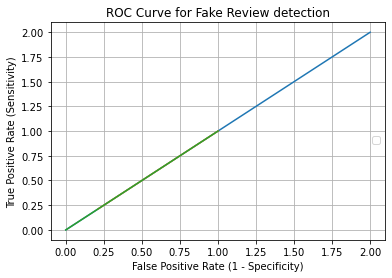

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve
plt.plot(roc_curve(y_test, y_pred3), roc_curve(y_test, y_pred3))
plt.title('ROC Curve for Fake Review detection')
plt.grid()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(bbox_to_anchor=(1.0, .5))
plt.show()

### Training the model
## Random Forest with HPT

In [24]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt','log2']
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
min_samples_split = [2, 5, 10, 14]
min_samples_leaf = [1, 2, 4, 6, 8]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


In [25]:
st = time.process_time()
rf=RandomForestClassifier()
rf_randomcv=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=10,cv=3,verbose=2,
                               random_state=100,n_jobs=-1)
# Fit the randomized model
rf_randomcv.fit(X_train_ns,y_train_ns)
et = time.process_time()
res = et - st
print('CPU Execution time:', res, 'seconds')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END criterion=gini, max_depth=120, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=1400; total time=18.9min
[CV] END criterion=gini, max_depth=670, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time= 8.4min
[CV] END criterion=entropy, max_depth=670, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=2000; total time=25.7min
[CV] END criterion=gini, max_depth=340, max_features=sqrt, min_samples_leaf=1, min_samples_split=14, n_estimators=2000; total time=37.6min
[CV] END criterion=gini, max_depth=340, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1400; total time=18.8min
[CV] END criterion=gini, max_depth=120, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=1400; total time=18.9min
[CV] END criterion=gini, max_depth=670, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_esti

In [26]:
rf_randomcv.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 120,
 'criterion': 'entropy'}

In [27]:
rf_randomcv

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=100, verbose=2)

In [28]:
best_random_grid = rf_randomcv.best_estimator_

In [29]:
y_pred4 = best_random_grid.predict(X_test)
print(confusion_matrix(y_test,y_pred4))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred4)))
print("Classification report: {}".format(classification_report(y_test,y_pred4)))

[[87078 23380]
 [ 4533 16263]]
Accuracy Score 0.7873360049979429
Classification report:               precision    recall  f1-score   support

           0       0.95      0.79      0.86    110458
           1       0.41      0.78      0.54     20796

    accuracy                           0.79    131254
   macro avg       0.68      0.79      0.70    131254
weighted avg       0.86      0.79      0.81    131254



In [30]:
# Print the model metrics
get_model_metrics(y_test, y_pred4 ,'Random Forest with HPT')

------ 

### Random Forest with HPT Model Metrics Summary : 

#### Confusion Matrix : 

array([[87078, 23380],
       [ 4533, 16263]])

,Model Name,Accuracy,Precision,Recall,AUC,F1,Brier Loss
0,Random Forest with HPT,0.79,0.41,0.78,0.79,0.54,0.2127


### Training the model
## XGBoost Classifier

In [31]:
st = time.process_time()
xgb_model = xgb.XGBClassifier(n_jobs = -1, objective = 'binary:logistic')
xgb_model.fit(X_train_ns, y_train_ns)
et = time.process_time()
res = et - st
print('CPU Execution time:', res, 'seconds')

[03:47:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU Execution time: 59.9117369999999 seconds


In [32]:
y_pred5 = xgb_model.predict(X_test)
predictions = [round(value) for value in y_pred5]

In [33]:
accuracy = accuracy_score(y_test, predictions)
print(confusion_matrix(y_test,y_pred5))
print(accuracy_score(y_test,y_pred5))
print(classification_report(y_test,y_pred5))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[[87125 23333]
 [ 4534 16262]]
0.7876864705075655
              precision    recall  f1-score   support

           0       0.95      0.79      0.86    110458
           1       0.41      0.78      0.54     20796

    accuracy                           0.79    131254
   macro avg       0.68      0.79      0.70    131254
weighted avg       0.87      0.79      0.81    131254

Accuracy: 78.77%


In [34]:
# Print the model metrics
get_model_metrics(y_test, y_pred5 ,'XGBoost Classification')

------ 

### XGBoost Classification Model Metrics Summary : 

#### Confusion Matrix : 

array([[87125, 23333],
       [ 4534, 16262]])

,Model Name,Accuracy,Precision,Recall,AUC,F1,Brier Loss
0,XGBoost Classification,0.79,0.41,0.78,0.79,0.54,0.2123


### Training the model
## XGBoost Classification with Hyper Parameter Tuning(HPT)

In [35]:
from scipy import stats
st = time.process_time()
# A parameter grid for XGBoost
params = {
        'n_estimators' : stats.randint(150, 2000),
        'learning_rate': stats.uniform(0.05, 0.5),
        'min_child_weight': [1, 2, 3, 4, 5],
        'gamma': stats.uniform(0.1, 0.9),
        'subsample': stats.uniform(0.5, 1.0),
        'colsample_bytree': stats.uniform(0.5, 0.9),
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
        }

folds = 3
param_comb = 25
model_cv = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=param_comb, 
                              scoring='accuracy', n_jobs=-1, cv=folds, verbose=3, random_state=42, return_train_score=True)

# Fit the model
model_cv.fit(X_train_ns, y_train_ns)
et = time.process_time()
res = et - st
print('CPU Execution time:', res, 'seconds')

Fitting 3 folds for each of 25 candidates, totalling 75 fits


/Users/kshamajha/opt/anaconda3/envs/keras_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kshamajha/opt/anaconda3/envs/keras_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kshamajha/opt/anaconda3

/Users/kshamajha/opt/anaconda3/envs/keras_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kshamajha/opt/anaconda3/envs/keras_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:47:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3] END colsample_bytree=0.5899774242362026, gamma=0.5133240027692805, learning_rate=0.2168543055695109, max_depth=10, min_child_weight=3, n_estimators=1835, subsample=0.5564115790271003;, score=(train=0.801, test=0.798) total time=21.0min
[04:09:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3] END colsample_bytree=0.528

/Users/kshamajha/opt/anaconda3/envs/keras_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kshamajha/opt/anaconda3/envs/keras_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:35:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3] END colsample_bytree=1.1497988950401423, gamma=0.9446974381141752, learning_rate=0.05038938292050717, max_depth=6, min_child_weight=5, n_estimators=1334, subsample=0.8042422429595377;, score=(train=nan, test=nan) total time=   0.1s
[CV 3/3] END colsample_bytree=1.1497988950401423, gamma=0.9446974381141752, learning_rate=0.05038938292050717, max_depth=6, min_child_weight=5, n_estimators=1334, subsample=0.8042422429595377;, score=(train=nan, test=nan) total time=   0.1s
[CV 2/3] END colsample_bytree=0.9722807884690141, gamma=0.48875051677790415, learning_rate=0.19561457009902095, max_depth=5, min_child_weight=2, n_estimators=

/Users/kshamajha/opt/anaconda3/envs/keras_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kshamajha/opt/anaconda3/envs/keras_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kshamajha/opt/anaconda3

[CV 1/3] END colsample_bytree=1.1497988950401423, gamma=0.9446974381141752, learning_rate=0.05038938292050717, max_depth=6, min_child_weight=5, n_estimators=1334, subsample=0.8042422429595377;, score=(train=nan, test=nan) total time=   0.1s
[CV 1/3] END colsample_bytree=0.9722807884690141, gamma=0.48875051677790415, learning_rate=0.19561457009902095, max_depth=5, min_child_weight=2, n_estimators=1649, subsample=1.4737555188414593;, score=(train=nan, test=nan) total time=   0.1s
[CV 3/3] END colsample_bytree=0.9722807884690141, gamma=0.48875051677790415, learning_rate=0.19561457009902095, max_depth=5, min_child_weight=2, n_estimators=1649, subsample=1.4737555188414593;, score=(train=nan, test=nan) total time=   0.1s
[03:47:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error'

/Users/kshamajha/opt/anaconda3/envs/keras_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kshamajha/opt/anaconda3/envs/keras_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kshamajha/opt/anaconda3

[03:47:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3] END colsample_bytree=0.8370861069626263, gamma=0.9556428757689246, learning_rate=0.41599697090570253, max_depth=7, min_child_weight=5, n_estimators=1788, subsample=0.9458327528535911;, score=(train=0.805, test=0.792) total time=13.0min
[04:00:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3] END colsample_bytree=0.566

/Users/kshamajha/opt/anaconda3/envs/keras_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kshamajha/opt/anaconda3/envs/keras_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kshamajha/opt/anaconda3

CPU Execution time: 1346.2228120000004 seconds


In [36]:
# Print the best params and accuracy score for them 
print('Best params for XGBoost are:' + str(model_cv.best_params_))

Best params for XGBoost are:{'colsample_bytree': 0.8748589530833296, 'gamma': 0.8949522330269815, 'learning_rate': 0.21217251050263697, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 1646, 'subsample': 0.8180034749718639}


In [37]:
best_xgboost = model_cv.best_estimator_

In [38]:
y_pred6 = best_xgboost.predict(X_test)
predictions = [round(value) for value in y_pred6]

In [39]:
accuracy = accuracy_score(y_test, predictions)
print(confusion_matrix(y_test,y_pred6))
print(accuracy_score(y_test,y_pred6))
print(classification_report(y_test,y_pred6))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[[87005 23453]
 [ 4534 16262]]
0.7867722126563762
              precision    recall  f1-score   support

           0       0.95      0.79      0.86    110458
           1       0.41      0.78      0.54     20796

    accuracy                           0.79    131254
   macro avg       0.68      0.78      0.70    131254
weighted avg       0.86      0.79      0.81    131254

Accuracy: 78.68%


In [40]:
# Print the model metrics
get_model_metrics(y_test, y_pred6 ,'XGBoost Classification with HPT')

------ 

### XGBoost Classification with HPT Model Metrics Summary : 

#### Confusion Matrix : 

array([[87005, 23453],
       [ 4534, 16262]])

,Model Name,Accuracy,Precision,Recall,AUC,F1,Brier Loss
0,XGBoost Classification with HPT,0.79,0.41,0.78,0.78,0.54,0.2132


In [41]:
model_results.head(10)

,Model Name,Accuracy,Precision,Recall,AUC,F1,Brier Loss
0,Logistic Regression with unbalanced data,0.85,0.54,0.17,0.57,0.25,0.1547
1,Logistic Regression,0.79,0.42,0.77,0.78,0.54,0.2067
2,Random Forest,0.79,0.41,0.78,0.79,0.54,0.2128
3,Random Forest with HPT,0.79,0.41,0.78,0.79,0.54,0.2127
4,XGBoost Classification,0.79,0.41,0.78,0.79,0.54,0.2123
5,XGBoost Classification with HPT,0.79,0.41,0.78,0.78,0.54,0.2132


### Training the model
## Bernoulli Naive Bayes

In [42]:
from sklearn.naive_bayes import BernoulliNB

In [43]:
st = time.process_time()
# instantiate bernoulli NB object
bnb = BernoulliNB()
# fit
bnb.fit(X_train_ns,y_train_ns)
et = time.process_time()
res = et - st
print('CPU Execution time:', res, 'seconds')

CPU Execution time: 0.06750000000010914 seconds


In [44]:
# predict class
y_pred7 = bnb.predict(X_test)
predictions = [round(value) for value in y_pred7]

In [45]:
# predict probability
y_pred_proba =bnb.predict_proba(X_test)

In [46]:
accuracy = accuracy_score(y_test, predictions)
print(confusion_matrix(y_test,y_pred7))
print(accuracy_score(y_test,y_pred7))
print(classification_report(y_test,y_pred7))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[[82964 27494]
 [ 3780 17016]]
0.7617291663492161
              precision    recall  f1-score   support

           0       0.96      0.75      0.84    110458
           1       0.38      0.82      0.52     20796

    accuracy                           0.76    131254
   macro avg       0.67      0.78      0.68    131254
weighted avg       0.87      0.76      0.79    131254

Accuracy: 76.17%


In [47]:
# Print the model metrics
get_model_metrics(y_test, y_pred7 ,'Bernoulli Naive Bayes')

------ 

### Bernoulli Naive Bayes Model Metrics Summary : 

#### Confusion Matrix : 

array([[82964, 27494],
       [ 3780, 17016]])

,Model Name,Accuracy,Precision,Recall,AUC,F1,Brier Loss
0,Bernoulli Naive Bayes,0.76,0.38,0.82,0.78,0.52,0.2383


### Training the model
## Multinomial Naive Bayes

In [48]:
from sklearn.naive_bayes import MultinomialNB
st = time.process_time()
mnb = MultinomialNB()

# fit
mnb.fit(X_train_ns,y_train_ns)
et = time.process_time()
res = et - st
print('CPU Execution time:', res, 'seconds')

# predict class
y_pred8 = mnb.predict(X_test)

# predict probabilities
y_pred_proba = mnb.predict_proba(X_test)

CPU Execution time: 0.04210799999964365 seconds


In [49]:
predictions = [round(value) for value in y_pred8]

In [50]:
accuracy = accuracy_score(y_test, predictions)
print(confusion_matrix(y_test,y_pred8))
print(accuracy_score(y_test,y_pred8))
print(classification_report(y_test,y_pred8))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[[94560 15898]
 [12067  8729]]
0.7869398265957609
              precision    recall  f1-score   support

           0       0.89      0.86      0.87    110458
           1       0.35      0.42      0.38     20796

    accuracy                           0.79    131254
   macro avg       0.62      0.64      0.63    131254
weighted avg       0.80      0.79      0.79    131254

Accuracy: 78.69%


In [51]:
# Print the model metrics
get_model_metrics(y_test, y_pred8 ,'Multinomial Naive Bayes')

------ 

### Multinomial Naive Bayes Model Metrics Summary : 

#### Confusion Matrix : 

array([[94560, 15898],
       [12067,  8729]])

,Model Name,Accuracy,Precision,Recall,AUC,F1,Brier Loss
0,Multinomial Naive Bayes,0.79,0.35,0.42,0.64,0.38,0.2131


### Training the model
## Support Vector Classifier

In [52]:
from sklearn import svm

In [53]:
st = time.process_time()
svc = svm.SVC(kernel='linear', C=1).fit(X_train_ns, y_train_ns)
et = time.process_time()
res = et - st
print('CPU Execution time:', res, 'seconds')

[03:47:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3] END colsample_bytree=0.5899774242362026, gamma=0.5133240027692805, learning_rate=0.2168543055695109, max_depth=10, min_child_weight=3, n_estimators=1835, subsample=0.5564115790271003;, score=(train=0.805, test=0.792) total time=20.3min
[04:08:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3] END colsample_bytree=0.528

/Users/kshamajha/opt/anaconda3/envs/keras_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kshamajha/opt/anaconda3/envs/keras_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kshamajha/opt/anaconda3

[03:47:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3] END colsample_bytree=0.8370861069626263, gamma=0.9556428757689246, learning_rate=0.41599697090570253, max_depth=7, min_child_weight=5, n_estimators=1788, subsample=0.9458327528535911;, score=(train=0.801, test=0.797) total time=13.5min
[CV 1/3] END colsample_bytree=0.5572025152574213, gamma=0.379884089544096, learning_rate=0.2125916610133735, max_depth=5, min_child_weight=4, n_estimators=875, subsample=1.3872127425763265;, score=(train=nan, test=nan) total time=   0.1s
[CV 2/3] END colsample_bytree=0.5572025152574213, gamma=0.379884089544096, learning_rate=0.2125916610133735, max_depth=5, min_child_weight=4, n_estimators=87

/Users/kshamajha/opt/anaconda3/envs/keras_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kshamajha/opt/anaconda3/envs/keras_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kshamajha/opt/anaconda3

[03:47:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3] END colsample_bytree=0.8370861069626263, gamma=0.9556428757689246, learning_rate=0.41599697090570253, max_depth=7, min_child_weight=5, n_estimators=1788, subsample=0.9458327528535911;, score=(train=0.801, test=0.798) total time=13.6min
[04:01:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3] END colsample_bytree=0.924

/Users/kshamajha/opt/anaconda3/envs/keras_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kshamajha/opt/anaconda3/envs/keras_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kshamajha/opt/anaconda3

CPU Execution time: 2359.7350689999994 seconds


In [54]:
# predict class
y_pred9 = svc.predict(X_test)
predictions = [round(value) for value in y_pred9]

In [55]:
accuracy = accuracy_score(y_test, predictions)
print(confusion_matrix(y_test,y_pred9))
print(accuracy_score(y_test,y_pred9))
print(classification_report(y_test,y_pred9))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[[88479 21979]
 [ 5232 15564]]
0.7926844134274003
              precision    recall  f1-score   support

           0       0.94      0.80      0.87    110458
           1       0.41      0.75      0.53     20796

    accuracy                           0.79    131254
   macro avg       0.68      0.77      0.70    131254
weighted avg       0.86      0.79      0.81    131254

Accuracy: 79.27%


In [56]:
# Print the model metrics
get_model_metrics(y_test, y_pred9 ,'Support Vector Classifier')

------ 

### Support Vector Classifier Model Metrics Summary : 

#### Confusion Matrix : 

array([[88479, 21979],
       [ 5232, 15564]])

,Model Name,Accuracy,Precision,Recall,AUC,F1,Brier Loss
0,Support Vector Classifier,0.79,0.41,0.75,0.77,0.53,0.2073


### Training the model
## Decision Tree Classifier

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [58]:
# Create the parameter grid 
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [59]:
st = time.process_time()
dt = DecisionTreeClassifier(random_state=42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")
grid_search.fit(X_train_ns, y_train_ns)
et = time.process_time()
res = et - st
print('CPU Execution time:', res, 'seconds')

Fitting 4 folds for each of 50 candidates, totalling 200 fits
CPU Execution time: 3.7348830000000817 seconds


In [60]:
grid_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=5,
                       random_state=42)

In [61]:
dt_best = grid_search.best_estimator_

In [62]:
# predict class
y_pred10 = dt_best.predict(X_test)
predictions = [round(value) for value in y_pred10]

In [63]:
accuracy = accuracy_score(y_test, predictions)
print(confusion_matrix(y_test,y_pred10))
print(accuracy_score(y_test,y_pred10))
print(classification_report(y_test,y_pred10))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[[86684 23774]
 [ 4515 16281]]
0.7844713303975498
              precision    recall  f1-score   support

           0       0.95      0.78      0.86    110458
           1       0.41      0.78      0.54     20796

    accuracy                           0.78    131254
   macro avg       0.68      0.78      0.70    131254
weighted avg       0.86      0.78      0.81    131254

Accuracy: 78.45%


In [64]:
# Print the model metrics
get_model_metrics(y_test, y_pred10 ,'Decision Tree Classifier with HPT')

------ 

### Decision Tree Classifier with HPT Model Metrics Summary : 

#### Confusion Matrix : 

array([[86684, 23774],
       [ 4515, 16281]])

,Model Name,Accuracy,Precision,Recall,AUC,F1,Brier Loss
0,Decision Tree Classifier with HPT,0.78,0.41,0.78,0.78,0.54,0.2155


In [65]:
model_results.head(20)

,Model Name,Accuracy,Precision,Recall,AUC,F1,Brier Loss
0,Logistic Regression with unbalanced data,0.85,0.54,0.17,0.57,0.25,0.1547
1,Logistic Regression,0.79,0.42,0.77,0.78,0.54,0.2067
2,Random Forest,0.79,0.41,0.78,0.79,0.54,0.2128
3,Random Forest with HPT,0.79,0.41,0.78,0.79,0.54,0.2127
4,XGBoost Classification,0.79,0.41,0.78,0.79,0.54,0.2123
5,XGBoost Classification with HPT,0.79,0.41,0.78,0.78,0.54,0.2132
6,Bernoulli Naive Bayes,0.76,0.38,0.82,0.78,0.52,0.2383
7,Multinomial Naive Bayes,0.79,0.35,0.42,0.64,0.38,0.2131
8,Support Vector Classifier,0.79,0.41,0.75,0.77,0.53,0.2073
9,Decision Tree Classifier with HPT,0.78,0.41,0.78,0.78,0.54,0.2155


## ROC curve

<Figure size 432x288 with 0 Axes>

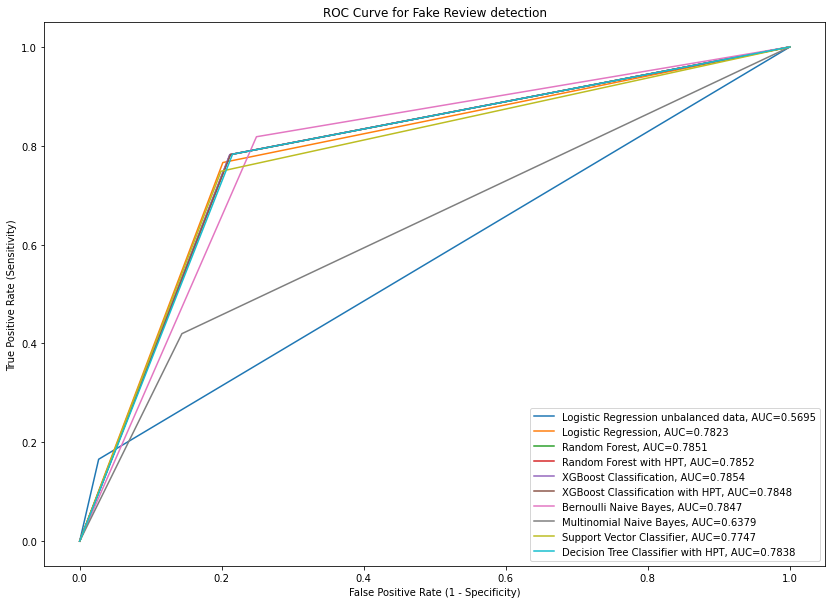

In [66]:
#set up plotting area
plt.figure(0).clf()
plt.figure(figsize=(14,10))
plt.title('ROC Curve for Fake Review detection')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

#plot ROC curve for logistic regression with unbalanced data model
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression unbalanced data, AUC="+str(auc))

#plot ROC curve for logistic regression model
fpr, tpr, _ = roc_curve(y_test, y_pred2)
auc = round(roc_auc_score(y_test, y_pred2), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))

#plot ROC curve for Random Forest model
fpr, tpr, _ = roc_curve(y_test, y_pred3)
auc = round(roc_auc_score(y_test, y_pred3), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

#plot ROC curve for Random Forest with HPT model
fpr, tpr, _ = roc_curve(y_test, y_pred4)
auc = round(roc_auc_score(y_test, y_pred4), 4)
plt.plot(fpr,tpr,label="Random Forest with HPT, AUC="+str(auc))

#plot ROC curve for XGBoost Classification model
fpr, tpr, _ = roc_curve(y_test, y_pred5)
auc = round(roc_auc_score(y_test, y_pred5), 4)
plt.plot(fpr,tpr,label="XGBoost Classification, AUC="+str(auc))

#plot ROC curve for XGBoost Classification with HPT model
fpr, tpr, _ = roc_curve(y_test, y_pred6)
auc = round(roc_auc_score(y_test, y_pred6), 4)
plt.plot(fpr,tpr,label="XGBoost Classification with HPT, AUC="+str(auc))

#plot ROC curve for Bernoulli Naive Bayes model
fpr, tpr, _ = roc_curve(y_test, y_pred7)
auc = round(roc_auc_score(y_test, y_pred7), 4)
plt.plot(fpr,tpr,label="Bernoulli Naive Bayes, AUC="+str(auc))

#plot ROC curve for Multinomial Naive Bayes model
fpr, tpr, _ = roc_curve(y_test, y_pred8)
auc = round(roc_auc_score(y_test, y_pred8), 4)
plt.plot(fpr,tpr,label="Multinomial Naive Bayes, AUC="+str(auc))

#plot ROC curve for Support Vector Classifier model
fpr, tpr, _ = roc_curve(y_test, y_pred9)
auc = round(roc_auc_score(y_test, y_pred9), 4)
plt.plot(fpr,tpr,label="Support Vector Classifier, AUC="+str(auc))

#plot ROC curve for Decision Tree Classifier with HPT model
fpr, tpr, _ = roc_curve(y_test, y_pred10)
auc = round(roc_auc_score(y_test, y_pred10), 4)
plt.plot(fpr,tpr,label="Decision Tree Classifier with HPT, AUC="+str(auc))

#add legend
plt.legend()